# Kaggle S5E8 Binary Classification with a Bank Dataset
This is an eda of the kaggle banking dataset


Start by importing packages

In [1]:
# Load requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score
from category_encoders import TargetEncoder, WOEEncoder

import xgboost as xgb
from xgboost import XGBClassifier


Load data 

In [2]:
df_raw_train = pd.read_csv('data/raw/train.csv')
df_raw_test = pd.read_csv('data/raw/test.csv')

display(df_raw_train)
print(df_raw_train.shape)
print(df_raw_test.shape)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


(750000, 18)
(250000, 17)


Check column type and set up basic categorical/numerical features. We start by setting the groups by the default dtypes

In [3]:
print(df_raw_train.info())

# Set target and cols we want to remove
target = ['y']
useless = ['id']

# Get categorical columns (object dtype)
cats = [name for name, dtype in df_raw_train.dtypes.items() if dtype == 'object' and name not in target+useless]
nums = [name for name, dtype in df_raw_train.dtypes.items() if dtype != 'object' and name not in target+useless]

print(cats)
print(nums)

assert len(target+useless+cats+nums) == df_raw_train.shape[1], 'Wrong number of features in the categories'
assert len(useless+cats+nums) == df_raw_test.shape[1], 'Wrong number of features in the categories'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB
None
['job', 'marital', 'education', 

Before we start deciding on data types, let's check the missing values situation

In [4]:
print('Number of missing values in train dataframe: ', df_raw_train.isnull().sum().sum())
print('Number of missing values in test dataframe: ', df_raw_test.isnull().sum().sum())

Number of missing values in train dataframe:  0
Number of missing values in test dataframe:  0


No missing values so no need to process. For deciding on data types for each column, We start looking at the ones that were loaded as objects. These are job, mrital, education, default, housing, load, contact, month, poutcome. The only one we might want to change here is month, we could use a trigonometric transformnation to capture its cyclical nature. Let's see if there is one by plotting positive events.

In [5]:
df_encode_train = df_raw_train.copy()
df_encode_test = df_raw_test.copy()

<Figure size 1200x600 with 0 Axes>

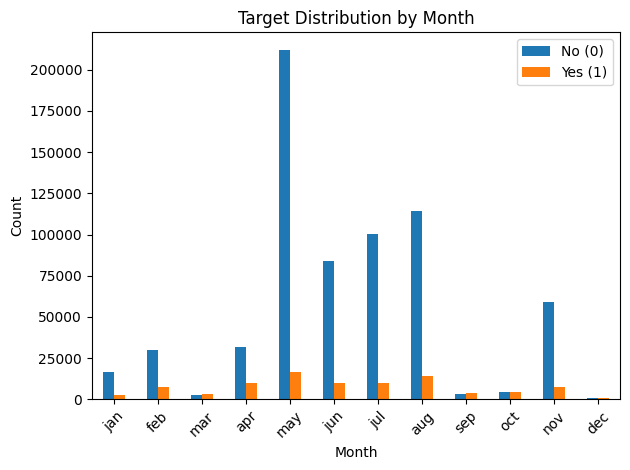

<Figure size 1200x600 with 0 Axes>

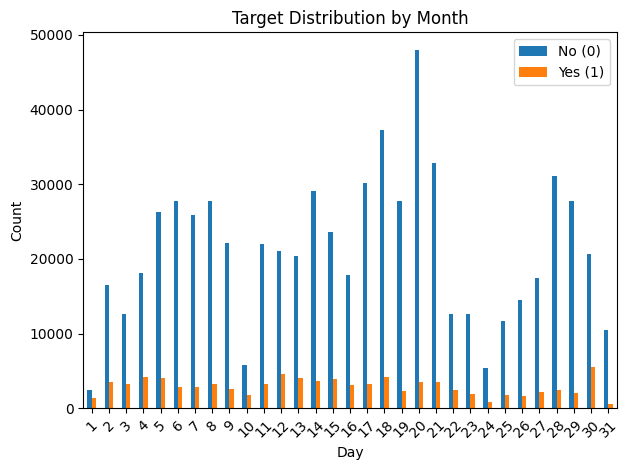

In [6]:
# Get counts of target values by month
month_events = df_encode_train.groupby('month')['y'].value_counts().unstack(fill_value=0)
# Define month order
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_events = month_events.reindex(month_order)
#display(month_events)

# Optional: Create a visualization
plt.figure(figsize=(12, 6))
month_events.plot(kind='bar')
plt.title('Target Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get counts by day of month
day_events = df_encode_train.groupby('day')['y'].value_counts().unstack(fill_value=0)
#display(day_events)

# Create visualization with sorted months
plt.figure(figsize=(12, 6))
day_events.plot(kind='bar')
plt.title('Target Distribution by Month')
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend(['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Both features show time periodicity, the analysis is in another notebook. In the section below we apply the sin/cos transform to the train and the test datasets

In [7]:
import math
# Encode month and day features
def time_encoding(df):
    # Since month is an object feature we need to transform it to a label
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    month_dict = {month:i+1 for i,month in enumerate(month_order)}
    df['month'] = df['month'].map(month_dict)
    
    # Add cyclical month feature
    df['month_sin'] = np.sin(2 * math.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * math.pi * df['month'] / 12)

    # Add cylical day features
    df['day_sin_375'] = np.sin(2 * math.pi * df['day'] / 3.75)
    df['day_cos_375'] = np.cos(2 * math.pi * df['day'] / 3.75)
    
    df['day_sin_443'] = np.sin(2 * math.pi * df['day'] / 4.43)
    df['day_cos_443'] = np.cos(2 * math.pi * df['day'] / 4.43)
    
    # Secondary cycle (marginally significant)
    df['day_sin_775'] = np.sin(2 * math.pi * df['day'] / 7.75)
    df['day_cos_775'] = np.cos(2 * math.pi * df['day'] / 7.75)
    
    # Polynomial backup for residual patterns
    df['day_squared'] = df['day'] ** 2

    return df

df_encode_train = time_encoding(df_encode_train)
df_encode_test = time_encoding(df_encode_test)


Age, Balance and Duration will be kept as numerical.

Let's look at the Campaign feature.

Campaign data distribution 
       Mean: 2.58, Std: 2.72, Median: 2.00, Skewness: 4.81


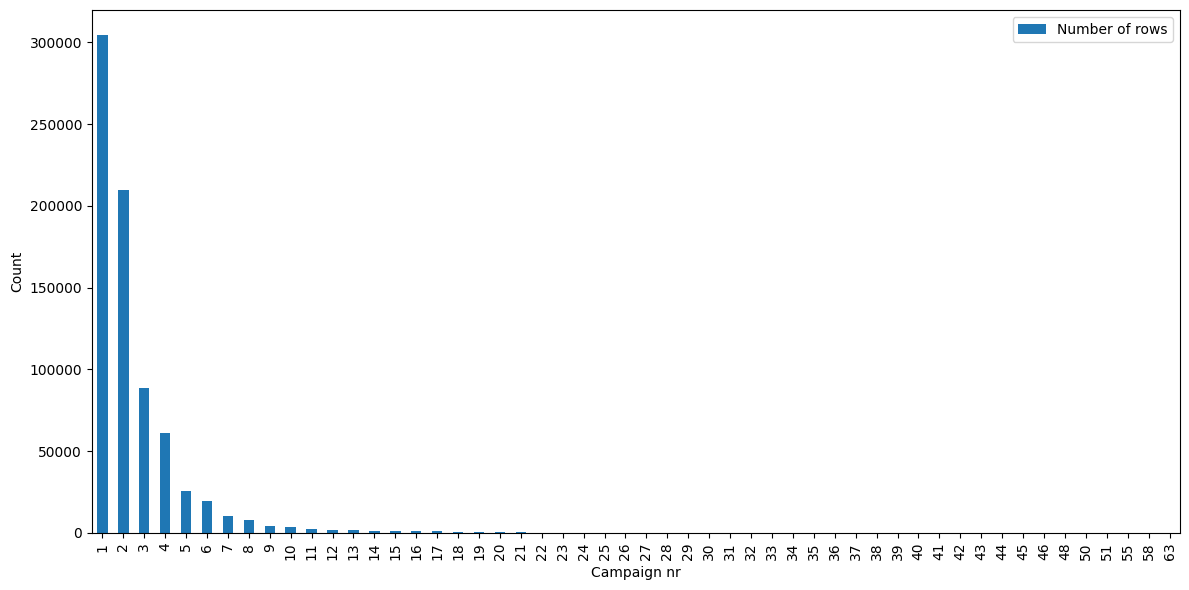

In [8]:
df_campaign_values = df_encode_train['campaign'].value_counts().sort_index()
#display(df_campaign)

# Statistical data
campaign_mean = df_encode_train['campaign'].mean()
campaign_std = df_encode_train['campaign'].std()
campaign_median = df_encode_train['campaign'].median()
campaign_skew = df_encode_train['campaign'].skew()

print(f'Campaign data distribution \n \
      Mean: {campaign_mean:.2f}, Std: {campaign_std:.2f}, Median: {campaign_median:.2f}, Skewness: {campaign_skew:.2f}')

# Plot
plt.figure(figsize=(12, 6))
df_campaign_values.plot(kind='bar')
plt.xlabel('Campaign nr')
plt.ylabel('Count')
plt.legend(['Number of rows']) #['No{0}', 'Yes [1]'])
plt.tight_layout()
plt.show()


Based on the graph we can create buckets with similar number of rows.

In [9]:
campaign_is_1 = np.sum(df_encode_train['campaign'] == 1)
campaign_is_23 = np.sum(df_encode_train['campaign'].isin([2,3]))
campaign_is_456 = np.sum(df_encode_train['campaign'].isin([4,5,6]))
campaign_is_7 = np.sum(df_encode_train['campaign'] > 7)

print(f'Number of rows for each bucket: \n \
    1: {campaign_is_1}, 2-3: {campaign_is_23}, 4-5-6: {campaign_is_456}, 7+: {campaign_is_7}')

Number of rows for each bucket: 
     1: 304481, 2-3: 298517, 4-5-6: 106316, 7+: 30326


In [10]:
# Manual bucketize the campaign feature: 1, 2-3, 4-6, 7+
assert df_encode_train['campaign'].max() >= df_encode_test['campaign'].max(), "Test value is larger than train value"

bucket_bins = [0, 1, 3, 6, df_encode_train['campaign'].max()]
bucket_labels = ['1', '2-3', '4-6', '7+']
df_encode_train['campaign_bucket'] = pd.cut(df_encode_train['campaign'], bins=bucket_bins, labels=bucket_labels, right=True)
df_encode_test['campaign_bucket'] = pd.cut(df_encode_test['campaign'], bins=bucket_bins, labels=bucket_labels, right=True)


We can use mutual informatin to see if our feature transformation was meaningful 

In [11]:

from sklearn.metrics import mutual_info_score
# Calculate mutual information for manual buckets
mi_bucket = mutual_info_score(df_encode_train['campaign_bucket'], df_encode_train[target[0]])

# Calculate mutual information for 36 levels as categorical
mi_original = mutual_info_score(df_encode_train['campaign'], df_encode_train[target[0]])

print(f'Compare original data Mutual Information {mi_original:.5} and the bucketized {mi_bucket:.5}')

Compare original data Mutual Information 0.0048591 and the bucketized 0.0045974


The bucketized verision is slightly worse, but overhead is reduced. We keep it and later test both in models

There are two features remainin Pdays and Previous. Let's explore them.

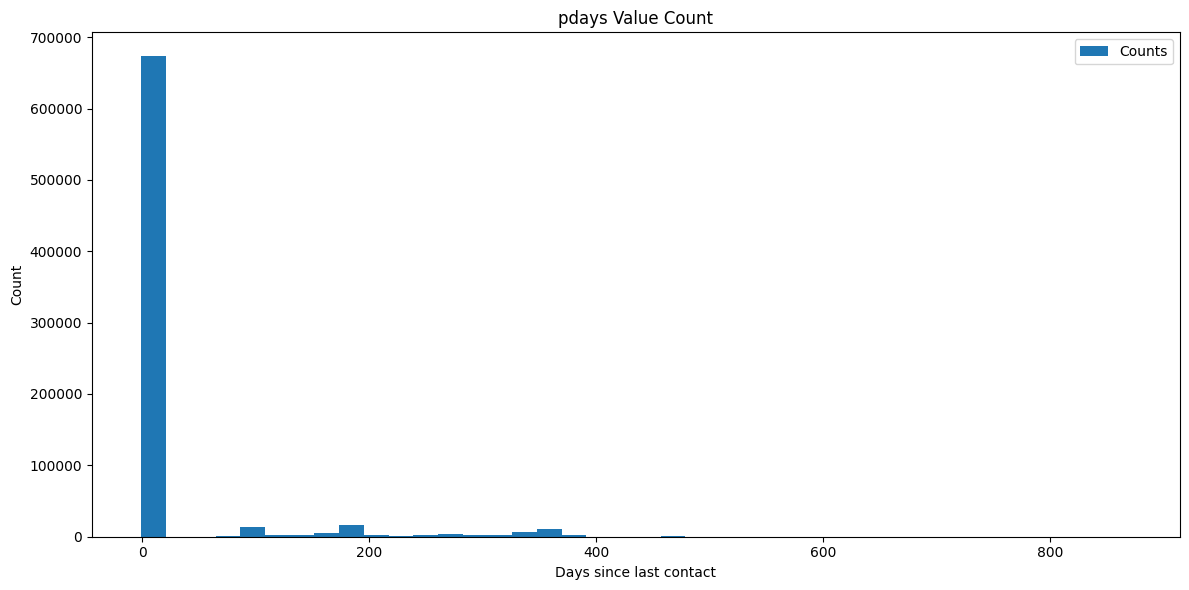

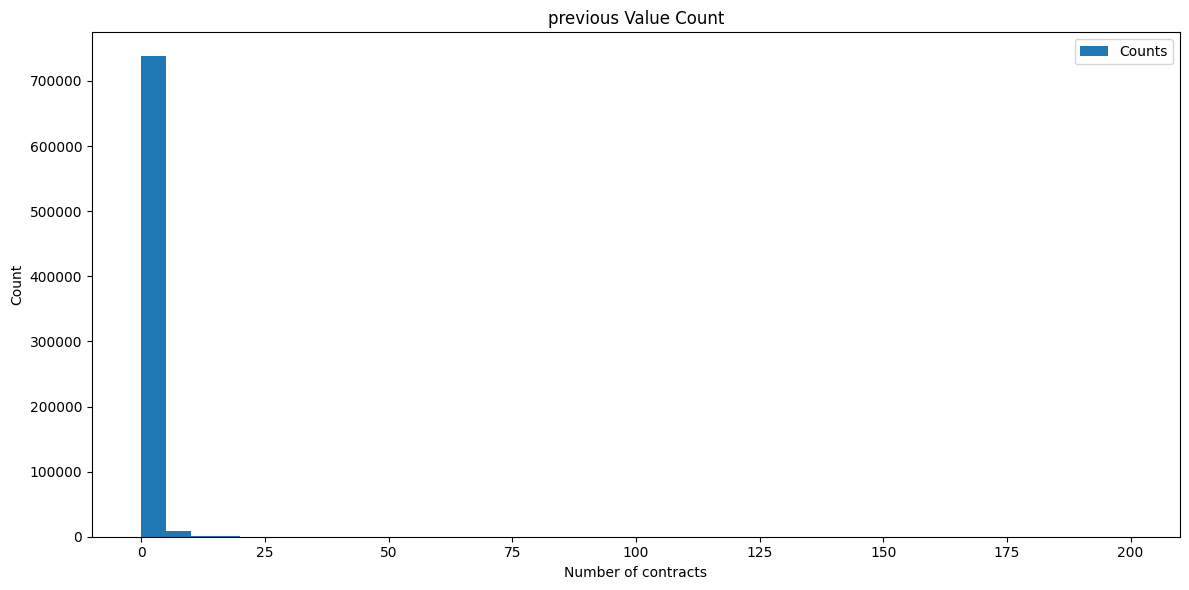

In [12]:
df_pdays_values = df_encode_train['pdays'].value_counts() #.to_frame()
#display(df_pdays_values)
df_previous_values = df_encode_train['previous'].value_counts().to_frame()
#display(df_previous_values)

plt.figure(figsize=(12,6))
plt.hist(df_encode_train['pdays'], bins=40)
plt.title('pdays Value Count')
plt.xlabel('Days since last contact')
plt.ylabel('Count')
plt.legend(['Counts'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.hist(df_encode_train['previous'], bins=40)
plt.title('previous Value Count')
plt.xlabel('Number of contracts')
plt.ylabel('Count')
plt.legend(['Counts'])
plt.tight_layout()
plt.show()


It shows the features are zero-inflated. 
We create hybrid features and  split each feature into two, one indicator and one pure count

In [13]:
def transform_pdays_hybrid(df):
    """
    Transform pdays into hybrid representation
    """
    # Step 1: Create binary indicator for previous contact
    df['had_previous_contact'] = (df['pdays'] != -1).astype(int)
    
    # Step 2: Create conditional numerical feature
    # Replace -1 with 0 to avoid negative values in numerical modeling
    df['days_since_contact'] = df['pdays'].where(df['pdays'] != -1, 0)
    
    # Validate transformations
    assert df['had_previous_contact'].sum() == (df['pdays'] != -1).sum(), "had_previous_contact transformation error"
    # ASSERTION 2: Values match original pdays when pdays != -1
    contact_mask = (df['pdays'] != -1)
    assert (df.loc[contact_mask, 'days_since_contact'] == df.loc[contact_mask, 'pdays']).all(), \
        "days_since_contact transformation error"    
    
    return df

df_encode_train = transform_pdays_hybrid(df_encode_train)
df_encoded_test = transform_pdays_hybrid(df_encode_test)


In [17]:
def transform_previous_hybrid(df):
    """
    Transform previous into hybrid representation
    """
    # Step 1: Create binary indicator for any contact history
    df['has_contact_history'] = (df['previous'] > 0).astype(int)
    
    # Step 2: Keep original count (already 0 for no-contact cases)
    df['contact_count'] = df['previous']
    
    
    # Validate transformations
    assert df['has_contact_history'].sum() == (df['previous'] > 0).sum(), "has_contact_history transformation error" 
    contact_mask = (df['previous'] > 0)
    assert (df.loc[contact_mask, 'contact_count'] == df.loc[contact_mask, 'previous']).all(), \
        "contact_count transformation error"    
    
    return df

df_encode_train = transform_previous_hybrid(df_encode_train)
df_encode_test = transform_previous_hybrid(df_encode_test)

In [ ]:
# Ordinal encode all cats features
def ord_trans(df, df1, cats):
    train_len = len(df)
    df_temp = pd.concat([df, df1], axis=0)
    unique_by_cats = df_temp[cats].nunique()
        
    for i, name in cats:
        df_temp[name], _ = df_temp[name].factorize()
        # Assert factorization worked correctly
        assert unique_by_cats[name] == df_temp[name].nunique(), \
            f"Factorization lost unique values for column '{name}'"
        
    df = df_temp.iloc[:train_len,:].copy()
    df1 = df_temp.iloc[train_len:,:].copy()
    df1 = df1.drop(columns=['y'])
    return df, df1

print(df_encode_train.shape, df_encode_test.shape)
df_encode_train, df_encode_test = ord_trans(df_encode_train, df_encode_test, cats)
print(df_encode_train.shape, df_encode_test.shape)

(750000, 32) (250000, 31)
(750000, 32) (250000, 31)


Run test model